In [1]:
import os
import numpy as np
from PIL import Image
from scipy.stats import entropy
from sklearn.ensemble import IsolationForest

folder = "../final_dataset/images_all"   
files = sorted(os.listdir(folder))

# Speicherstrukturen
sizes = []
aspect_ratios = []
mean_brightness = []
median_brightness = []
brightness_var = []
hist_entropy = []
unique_colors = []

# Hilfsfunktion zur Histogrammentropie (Graustufen)
def hist_entropy_gray(arr):
    hist, _ = np.histogram(arr, bins=256, range=(0,255), density=True)
    return entropy(hist + 1e-7)

# Über alle Bilder iterieren
for f in files:
    path = os.path.join(folder, f)

    try:
        img = Image.open(path)
    except:
        print("Defektes Bild (nicht lesbar):", f)
        continue

    # Bildgrößen
    w, h = img.size
    sizes.append((w, h))
    aspect_ratios.append(w / h)

    # Helligkeit (Graustufen)
    gray = img.convert("L")
    arr = np.array(gray)

    mean_brightness.append(arr.mean())
    median_brightness.append(np.median(arr))
    brightness_var.append(arr.var())

    # Histogramm-Entropie
    hist_entropy.append(hist_entropy_gray(arr))


# In Arrays umwandeln
sizes = np.array(sizes)
aspect_ratios = np.array(aspect_ratios)
mean_brightness = np.array(mean_brightness)
median_brightness = np.array(median_brightness)
brightness_var = np.array(brightness_var)
hist_entropy = np.array(hist_entropy)
unique_colors = np.array(unique_colors)

print("Anzahl analysierter Bilder:", len(files))


Defektes Bild (nicht lesbar): .DS_Store
Defektes Bild (nicht lesbar): 0_instances_default.json
Anzahl analysierter Bilder: 700


In [2]:
low_bright_idx = np.where(mean_brightness < np.percentile(mean_brightness, 1))[0]
high_bright_idx = np.where(mean_brightness > np.percentile(mean_brightness, 99))[0]

print("Extrem dunkle Bilder:", low_bright_idx)
print("Extrem helle Bilder:", high_bright_idx)


Extrem dunkle Bilder: [ 76  95 117 204 286 508 582]
Extrem helle Bilder: [370 381 382 383 398 399 414]


In [3]:
from sklearn.preprocessing import StandardScaler

X = np.vstack([
    mean_brightness,
    median_brightness,
    brightness_var,
    hist_entropy
]).T

X_scaled = StandardScaler().fit_transform(X)

clf = IsolationForest(contamination=0.05, random_state=42)
labels = clf.fit_predict(X_scaled)

iso_outliers = np.where(labels == -1)[0]
print("Histogramm-/Helligkeits-Outlier:", iso_outliers)


Histogramm-/Helligkeits-Outlier: [ 76  95 117 171 204 237 240 243 247 252 286 300 340 357 385 387 400 443
 444 461 472 476 485 486 487 488 489 494 495 496 497 498 499 500 582]


In [4]:
import matplotlib.pyplot as plt
from PIL import Image
import os

def show_grid(indices, folder, files, cols=5):
    plt.figure(figsize=(12, 12))
    
    for i, idx in enumerate(indices):
        img = Image.open(os.path.join(folder, files[idx]))
        plt.subplot(len(indices)//cols + 1, cols, i+1)
        plt.imshow(img)
        plt.title(files[idx], fontsize=6)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()


Dunkle Bilder


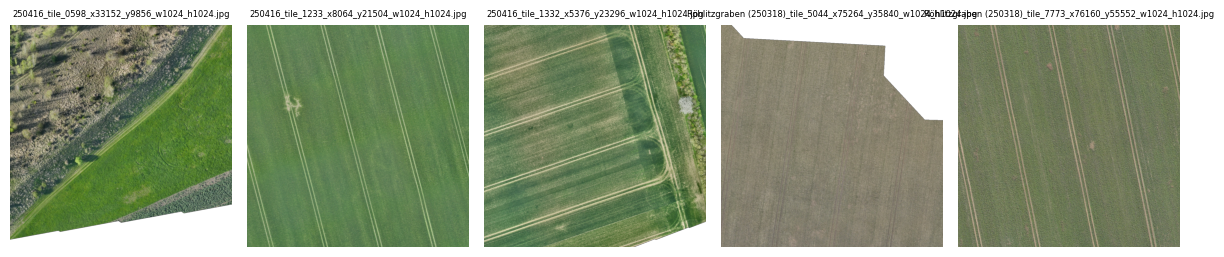

Helle Bilder


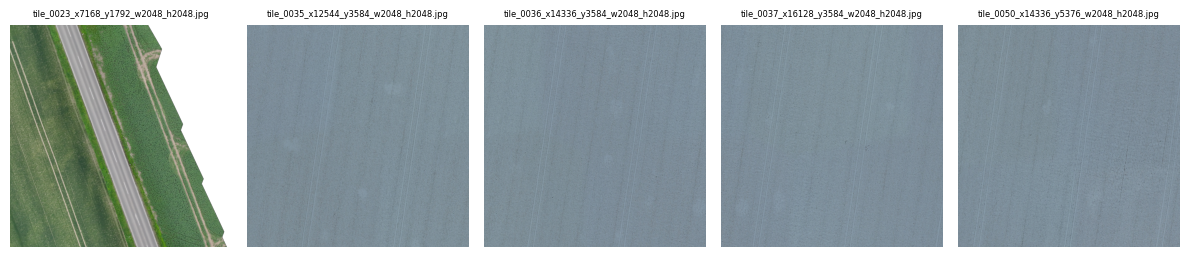

Iso-Outlier


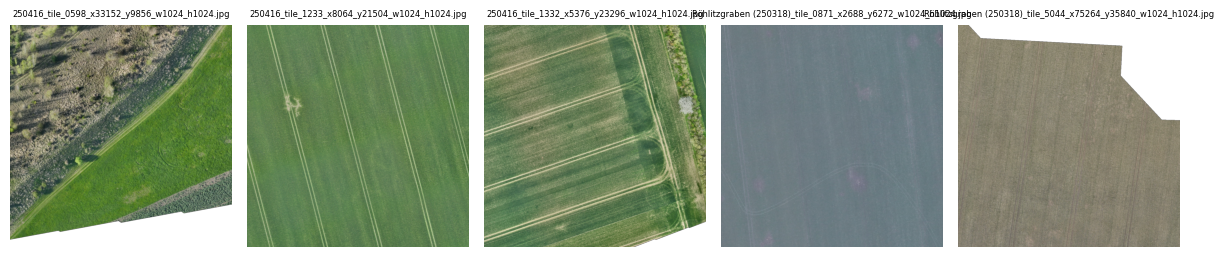

In [5]:
print("Dunkle Bilder")
show_grid(low_bright_idx[:5], folder, files)  

print("Helle Bilder")
show_grid(high_bright_idx[:5], folder, files) 

print("Iso-Outlier")
show_grid(iso_outliers[:5], folder, files)  

EfficentNet -> PCA -> UMAP

In [6]:
import json
import os

# Pfade anpassen
ann_path = "../final_dataset/images_all/0_instances_default.json"
img_root = "../final_dataset/images_all/" 

with open(ann_path, "r") as f:
    coco = json.load(f)

images = {img["id"]: img for img in coco["images"]}  # image_id -> image-dict

# Alle image_ids, die mindestens eine Annotation mit category_id == 1 (Mäuseschäden) haben
mouse_image_ids = set(
    ann["image_id"]
    for ann in coco["annotations"]
    if ann["category_id"] == 1
)

print("Anzahl Bilder mit Mäuseschäden:", len(mouse_image_ids))

# Liste von Bildpfaden nur für Kategorie 1
mouse_image_paths = [
    os.path.join(img_root, images[img_id]["file_name"])
    for img_id in sorted(mouse_image_ids)
]

print(mouse_image_paths[:5])


Anzahl Bilder mit Mäuseschäden: 210
['../final_dataset/images_all/250416_tile_0092_x36736_y896_w1024_h1024.jpg', '../final_dataset/images_all/250416_tile_0093_x37632_y896_w1024_h1024.jpg', '../final_dataset/images_all/250416_tile_0094_x38528_y896_w1024_h1024.jpg', '../final_dataset/images_all/250416_tile_0095_x39424_y896_w1024_h1024.jpg', '../final_dataset/images_all/250416_tile_0141_x34944_y1792_w1024_h1024.jpg']


In [7]:
mouse_annotations = [
    ann for ann in coco["annotations"]
    if ann["category_id"] == 1
]

print("Anzahl aller Mäuseschaden-Annotationen:", len(mouse_annotations))


Anzahl aller Mäuseschaden-Annotationen: 646


In [8]:
from PIL import Image

crops = []  # Liste aus (crop_image, annotation_id, image_path)

for ann in mouse_annotations:
    
    img_id = ann["image_id"]
    bbox = ann["bbox"]  # [x, y, w, h]
    file_name = images[img_id]["file_name"]
    img_path = os.path.join(img_root, file_name)

    # Bild öffnen
    img = Image.open(img_path).convert("RGB")
    
    x, y, w, h = bbox
    x2 = x + w
    y2 = y + h

    # Crop schneiden
    crop = img.crop((x, y, x2, y2))
    
    crops.append((crop, ann["id"], img_path))

print("Crops gesamt:", len(crops))


Crops gesamt: 646


In [11]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CropDataset(Dataset):
    def __init__(self, crops, transform=None):
        self.crops = crops    # Liste aus (PIL_Image, ann_id, image_path)
        self.transform = transform
        
    def __len__(self):
        return len(self.crops)
    
    def __getitem__(self, idx):
        img, ann_id, img_path = self.crops[idx]
        if self.transform:
            img = self.transform(img)
        return img, ann_id, img_path  # ann_id kann später hilfreich sein

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),])

dataset = CropDataset(
    crops,
    transform=transform  # gleiche transforms wie vorher: Resize, ToTensor, Normalize
)

loader = DataLoader(dataset, batch_size=32, shuffle=False)


In [ ]:
import timm

models = timm.list_models('*efficientnet*', pretrained=True)
for m in models:
    print(m)

In [12]:
import timm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

model = timm.create_model(
    "tf_efficientnetv2_l.in21k_ft_in1k",
    pretrained=True,
    num_classes=0,        # remove classification head
    global_pool="avg"     # output = single feature vector
).to(device)

model.eval()
print("Feature-Dim:", model.num_features)


/home/gast/Khanh/miniforge3/envs/torchvision_gpu_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Feature-Dim: 1280


In [13]:
import numpy as np

all_features = []

with torch.no_grad():
    for imgs, ann_ids, img_paths in loader:
        imgs = imgs.to(device)
        feats = model(imgs)               # (B, feature_dim)
        feats = feats.cpu().numpy()
        all_features.append(feats)

all_features = np.concatenate(all_features, axis=0)
print("Feature-Matrix:", all_features.shape)


Feature-Matrix: (646, 1280)


In [15]:
norm_features = all_features / np.linalg.norm(all_features, axis=1, keepdims=True)


In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=150, random_state=42)
features_pca = pca.fit_transform(norm_features)

print(features_pca.shape)



(646, 150)


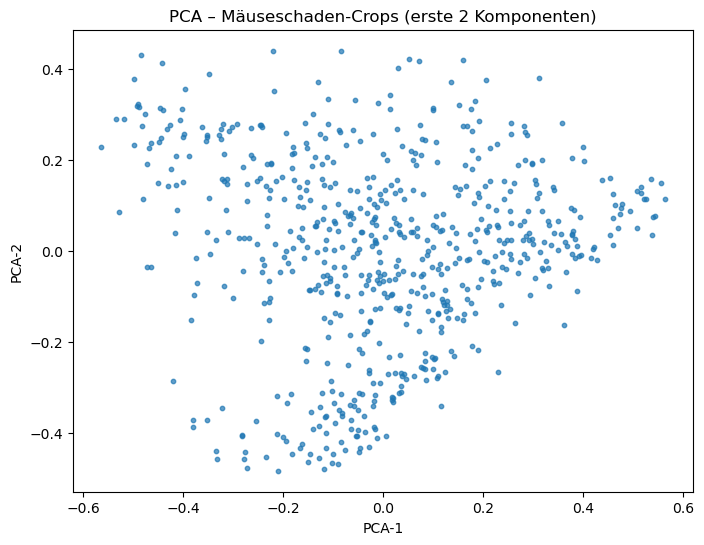

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(
    features_pca[:, 0],
    features_pca[:, 1],
    s=10,
    alpha=0.7
)
plt.title("PCA – Mäuseschaden-Crops (erste 2 Komponenten)")
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.show()

In [18]:
import umap

reducer = umap.UMAP(
    n_components=2,
    n_neighbors=30,
    min_dist=0.0,
    metric="cosine",
    random_state=42
)

embedding = reducer.fit_transform(features_pca)
print(embedding.shape)

/home/gast/Khanh/miniforge3/envs/torchvision_gpu_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(646, 2)


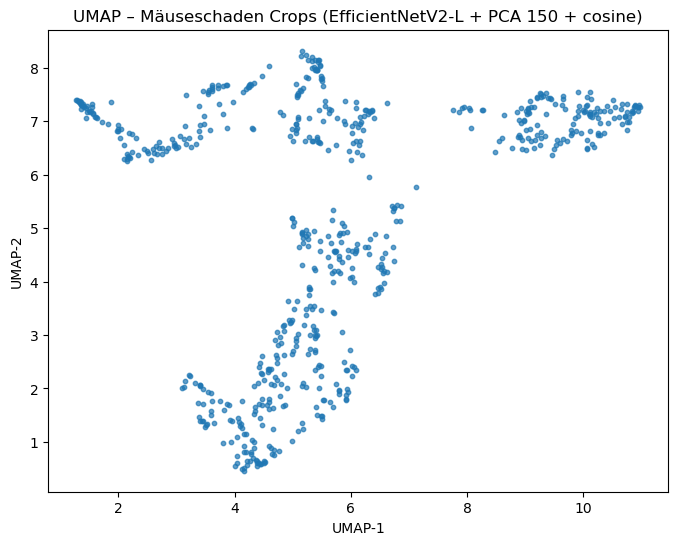

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    s=10,
    alpha=0.7
)
plt.title("UMAP – Mäuseschaden Crops (EfficientNetV2-L + PCA 150 + cosine)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

Clustering

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

k = 5  # kannst du später variieren

kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
k_labels = kmeans.fit_predict(embedding)  # Shape: (N,)

print("Clustergrößen (K-Means):")
for i in range(k):
    print(f"Cluster {i}: {(k_labels == i).sum()} Punkte")


Clustergrößen (K-Means):
Cluster 0: 101 Punkte
Cluster 1: 172 Punkte
Cluster 2: 112 Punkte
Cluster 3: 141 Punkte
Cluster 4: 120 Punkte


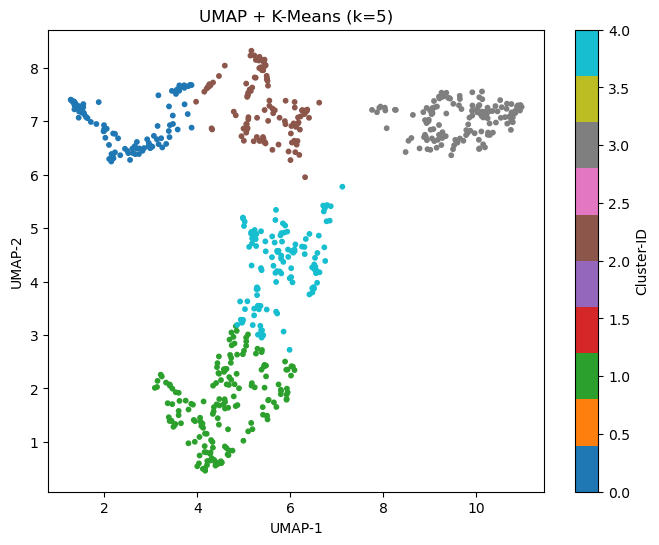

In [21]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=k_labels,
    s=10,
    cmap="tab10"
)
plt.title(f"UMAP + K-Means (k={k})")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(scatter, label="Cluster-ID")
plt.show()


In [25]:
from math import ceil
import matplotlib.pyplot as plt

def show_cluster_samples(labels, cluster_id, crops, max_images=16):
    """
    labels: Array der Länge N (Cluster IDs pro Punkt)
    cluster_id: Cluster, der angezeigt werden soll (z. B. 0,1,2,... oder -1)
    crops: Liste [(PIL_Image, ann_id, img_path), ...]
    """
    idxs = np.where(labels == cluster_id)[0]
    if len(idxs) == 0:
        print(f"Cluster {cluster_id}: keine Punkte")
        return
    
    n = min(max_images, len(idxs))
    idxs = idxs[:n]
    
    cols = 4
    rows = ceil(n / cols)
    
    plt.figure(figsize=(3*cols, 3*rows))
    for i, idx in enumerate(idxs):
        img, ann_id, img_path = crops[idx]
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"id={ann_id}")
        print(f"Cluster {cluster_id}, Index {idx}: ann_id={ann_id}, file={img_path}")
    plt.suptitle(f"Beispiele – Cluster {cluster_id}")
    plt.tight_layout()
    plt.show()


Cluster 0, Index 37: ann_id=80, file=../final_dataset/images_all/250416_tile_0448_x35840_y7168_w1024_h1024.jpg
Cluster 0, Index 68: ann_id=142, file=../final_dataset/images_all/Röhlitzgraben (250318)_tile_0251_x2688_y1792_w1024_h1024.jpg
Cluster 0, Index 133: ann_id=208, file=../final_dataset/images_all/Steinbrüche (250315)_tile_0021_x14336_y1792_w2048_h2048.jpg
Cluster 0, Index 134: ann_id=209, file=../final_dataset/images_all/Steinbrüche (250315)_tile_0021_x14336_y1792_w2048_h2048.jpg
Cluster 0, Index 135: ann_id=210, file=../final_dataset/images_all/Steinbrüche (250315)_tile_0021_x14336_y1792_w2048_h2048.jpg
Cluster 0, Index 136: ann_id=211, file=../final_dataset/images_all/Steinbrüche (250315)_tile_0021_x14336_y1792_w2048_h2048.jpg
Cluster 0, Index 137: ann_id=212, file=../final_dataset/images_all/Steinbrüche (250315)_tile_0021_x14336_y1792_w2048_h2048.jpg
Cluster 0, Index 138: ann_id=213, file=../final_dataset/images_all/Steinbrüche (250315)_tile_0021_x14336_y1792_w2048_h20

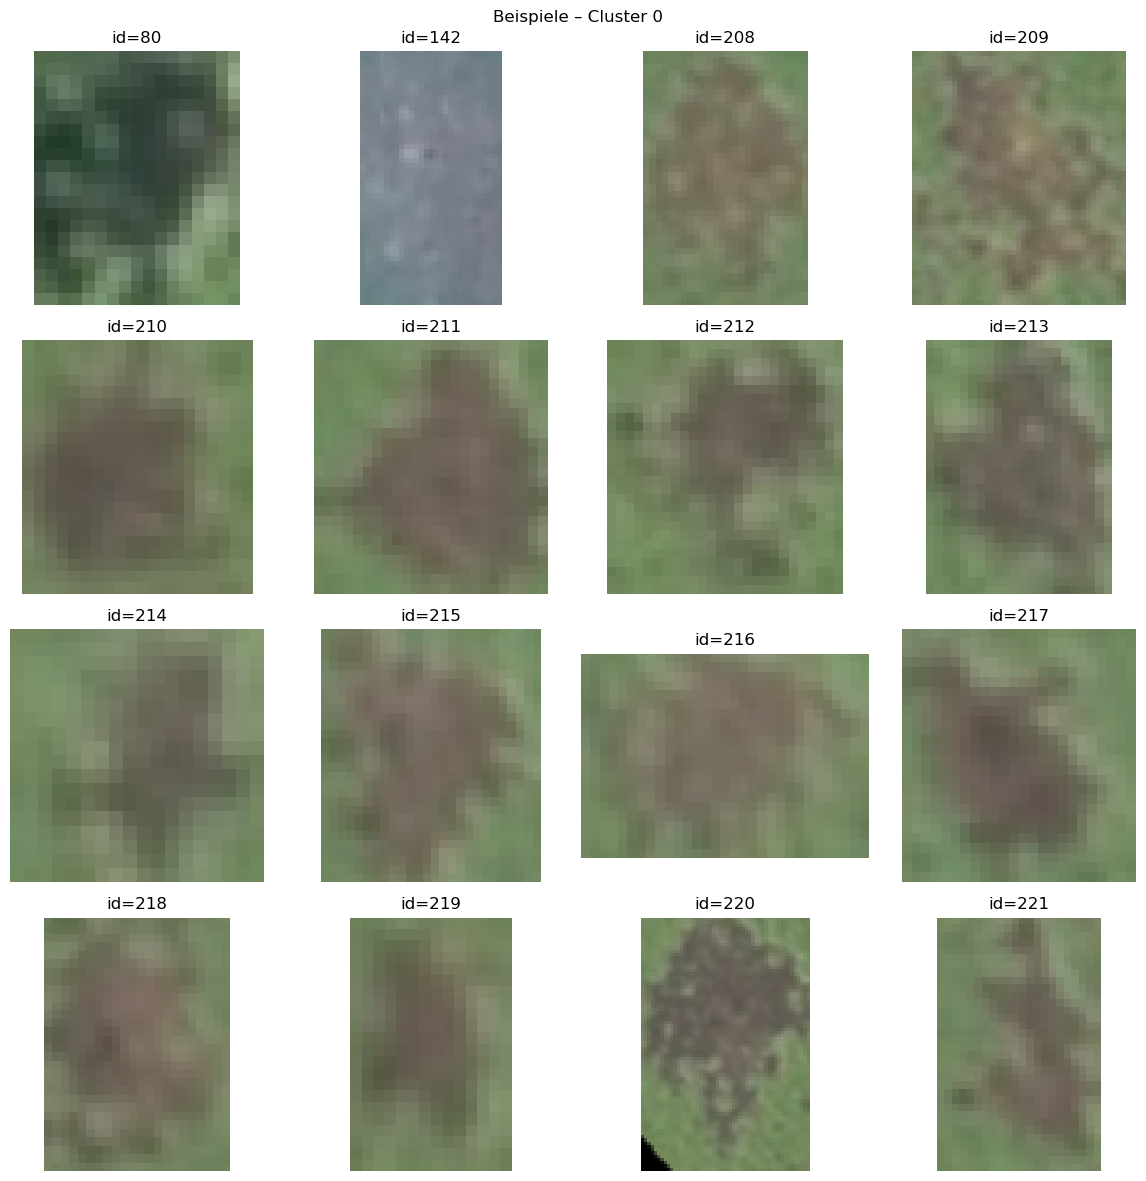

Cluster 1, Index 30: ann_id=64, file=../final_dataset/images_all/250416_tile_0250_x41216_y3584_w1024_h1024.jpg
Cluster 1, Index 31: ann_id=65, file=../final_dataset/images_all/250416_tile_0298_x38528_y4480_w1024_h1024.jpg
Cluster 1, Index 41: ann_id=85, file=../final_dataset/images_all/250416_tile_0449_x36736_y7168_w1024_h1024.jpg
Cluster 1, Index 73: ann_id=148, file=../final_dataset/images_all/Röhlitzgraben (250318)_tile_5037_x68992_y35840_w1024_h1024.jpg
Cluster 1, Index 78: ann_id=153, file=../final_dataset/images_all/Röhlitzgraben (250318)_tile_5037_x68992_y35840_w1024_h1024.jpg
Cluster 1, Index 112: ann_id=187, file=../final_dataset/images_all/Röhlitzgraben (250318)_tile_7526_x77056_y53760_w1024_h1024.jpg
Cluster 1, Index 270: ann_id=355, file=../final_dataset/images_all/tile_0305_x1792_y28672_w2048_h2048.jpg
Cluster 1, Index 271: ann_id=356, file=../final_dataset/images_all/tile_0305_x1792_y28672_w2048_h2048.jpg
Cluster 1, Index 272: ann_id=357, file=../final_dataset/images_a

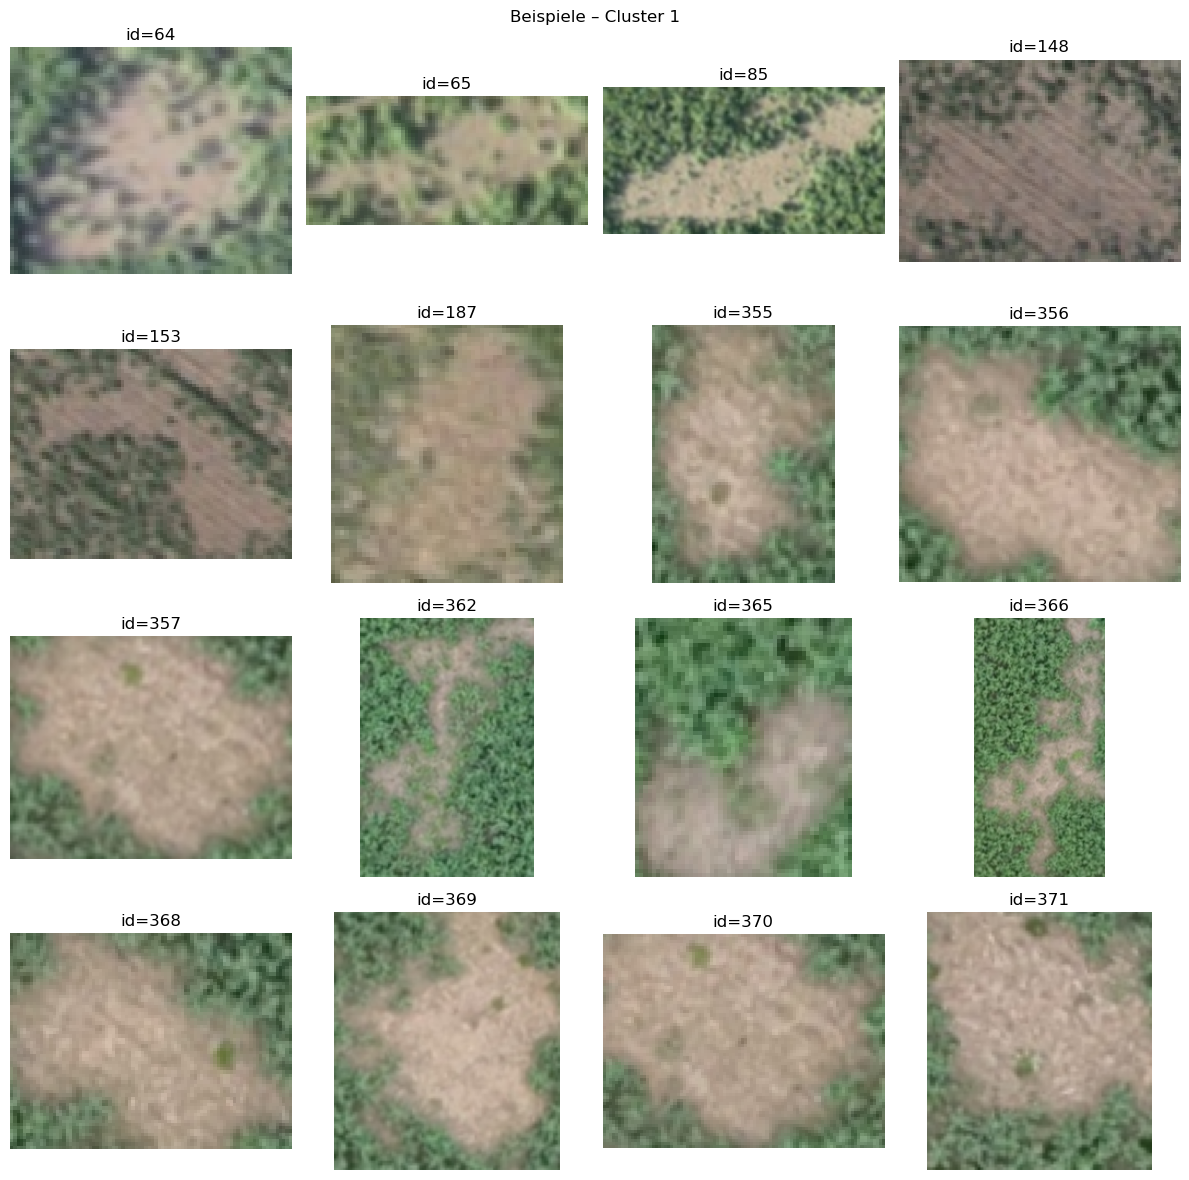

Cluster 2, Index 1: ann_id=6, file=../final_dataset/images_all/250416_tile_0093_x37632_y896_w1024_h1024.jpg
Cluster 2, Index 2: ann_id=7, file=../final_dataset/images_all/250416_tile_0093_x37632_y896_w1024_h1024.jpg
Cluster 2, Index 4: ann_id=10, file=../final_dataset/images_all/250416_tile_0094_x38528_y896_w1024_h1024.jpg
Cluster 2, Index 5: ann_id=12, file=../final_dataset/images_all/250416_tile_0095_x39424_y896_w1024_h1024.jpg
Cluster 2, Index 7: ann_id=17, file=../final_dataset/images_all/250416_tile_0142_x35840_y1792_w1024_h1024.jpg
Cluster 2, Index 8: ann_id=18, file=../final_dataset/images_all/250416_tile_0144_x37632_y1792_w1024_h1024.jpg
Cluster 2, Index 11: ann_id=22, file=../final_dataset/images_all/250416_tile_0146_x39424_y1792_w1024_h1024.jpg
Cluster 2, Index 15: ann_id=34, file=../final_dataset/images_all/250416_tile_0193_x35840_y2688_w1024_h1024.jpg
Cluster 2, Index 16: ann_id=36, file=../final_dataset/images_all/250416_tile_0195_x37632_y2688_w1024_h1024.jpg
Cluster 2, In

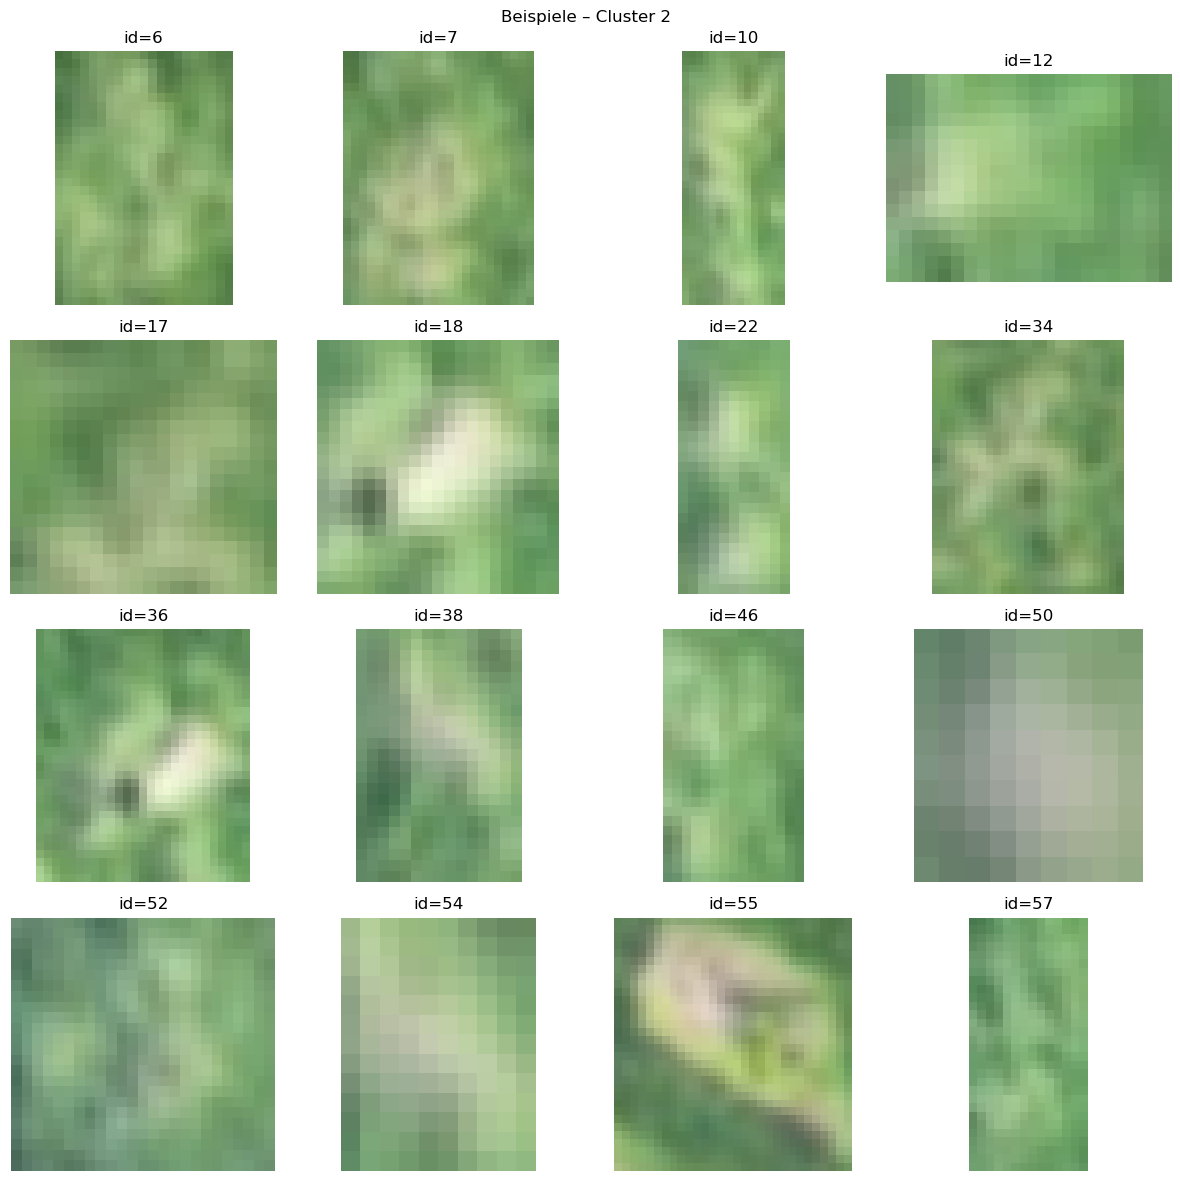

Cluster 3, Index 0: ann_id=2, file=../final_dataset/images_all/250416_tile_0092_x36736_y896_w1024_h1024.jpg
Cluster 3, Index 3: ann_id=8, file=../final_dataset/images_all/250416_tile_0093_x37632_y896_w1024_h1024.jpg
Cluster 3, Index 6: ann_id=14, file=../final_dataset/images_all/250416_tile_0141_x34944_y1792_w1024_h1024.jpg
Cluster 3, Index 9: ann_id=20, file=../final_dataset/images_all/250416_tile_0146_x39424_y1792_w1024_h1024.jpg
Cluster 3, Index 10: ann_id=21, file=../final_dataset/images_all/250416_tile_0146_x39424_y1792_w1024_h1024.jpg
Cluster 3, Index 12: ann_id=23, file=../final_dataset/images_all/250416_tile_0146_x39424_y1792_w1024_h1024.jpg
Cluster 3, Index 14: ann_id=32, file=../final_dataset/images_all/250416_tile_0192_x34944_y2688_w1024_h1024.jpg
Cluster 3, Index 17: ann_id=37, file=../final_dataset/images_all/250416_tile_0195_x37632_y2688_w1024_h1024.jpg
Cluster 3, Index 19: ann_id=39, file=../final_dataset/images_all/250416_tile_0195_x37632_y2688_w1024_h1024.jpg
Cluster 3

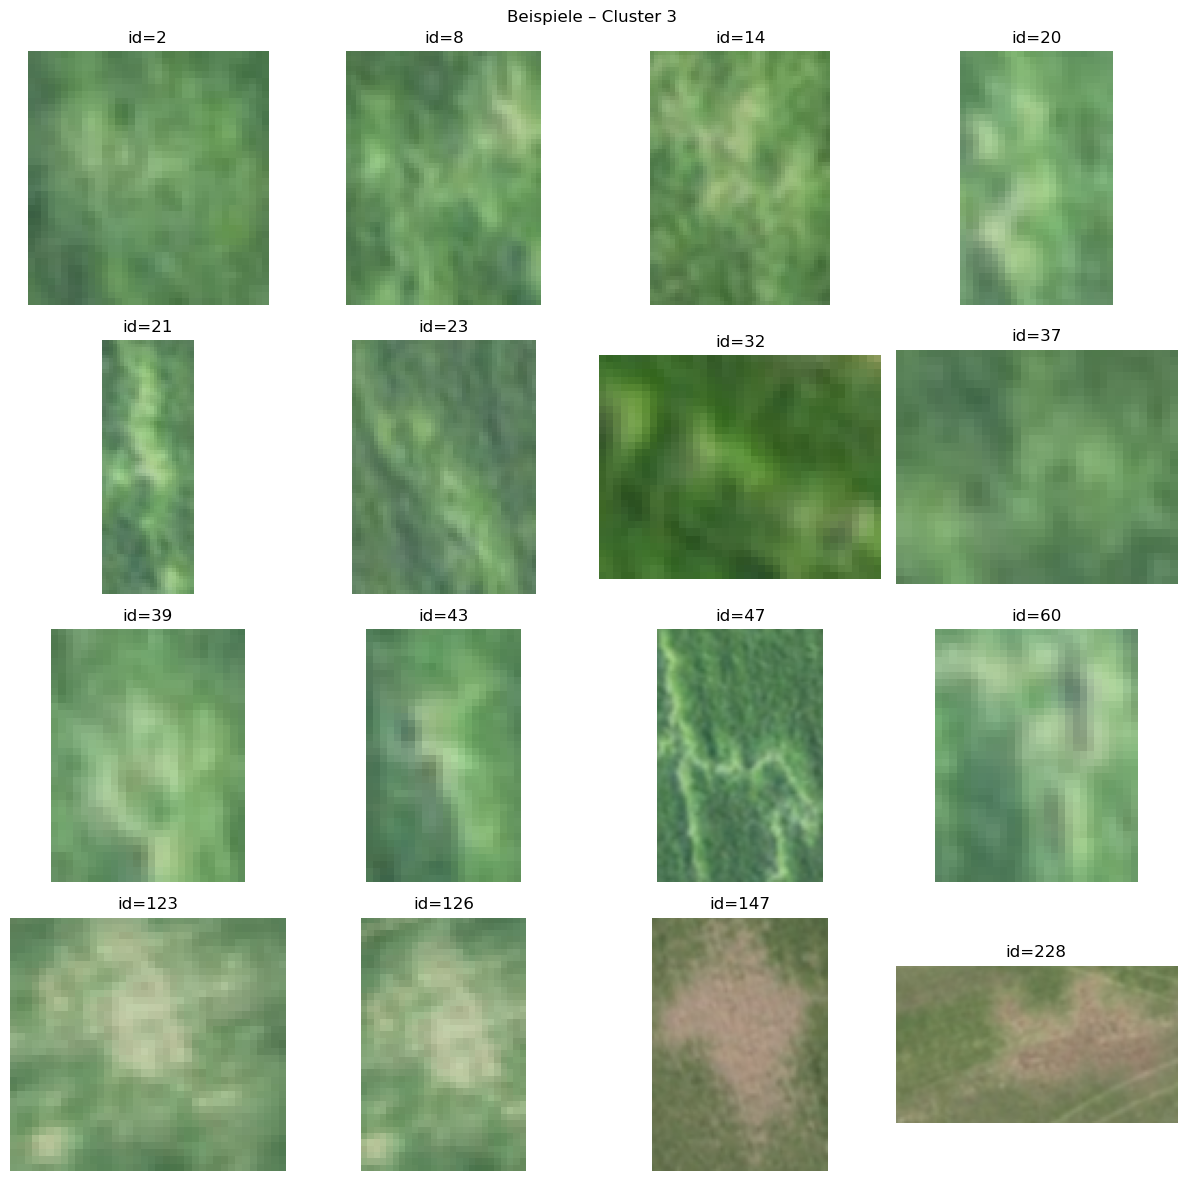

Cluster 4, Index 13: ann_id=29, file=../final_dataset/images_all/250416_tile_0147_x40320_y1792_w1024_h1024.jpg
Cluster 4, Index 33: ann_id=69, file=../final_dataset/images_all/250416_tile_0301_x41216_y4480_w1024_h1024.jpg
Cluster 4, Index 74: ann_id=149, file=../final_dataset/images_all/Röhlitzgraben (250318)_tile_5037_x68992_y35840_w1024_h1024.jpg
Cluster 4, Index 79: ann_id=154, file=../final_dataset/images_all/Röhlitzgraben (250318)_tile_5037_x68992_y35840_w1024_h1024.jpg
Cluster 4, Index 83: ann_id=158, file=../final_dataset/images_all/Röhlitzgraben (250318)_tile_5038_x69888_y35840_w1024_h1024.jpg
Cluster 4, Index 84: ann_id=159, file=../final_dataset/images_all/Röhlitzgraben (250318)_tile_5038_x69888_y35840_w1024_h1024.jpg
Cluster 4, Index 85: ann_id=160, file=../final_dataset/images_all/Röhlitzgraben (250318)_tile_5041_x72576_y35840_w1024_h1024.jpg
Cluster 4, Index 86: ann_id=161, file=../final_dataset/images_all/Röhlitzgraben (250318)_tile_5041_x72576_y35840_w1024_h1024.jp

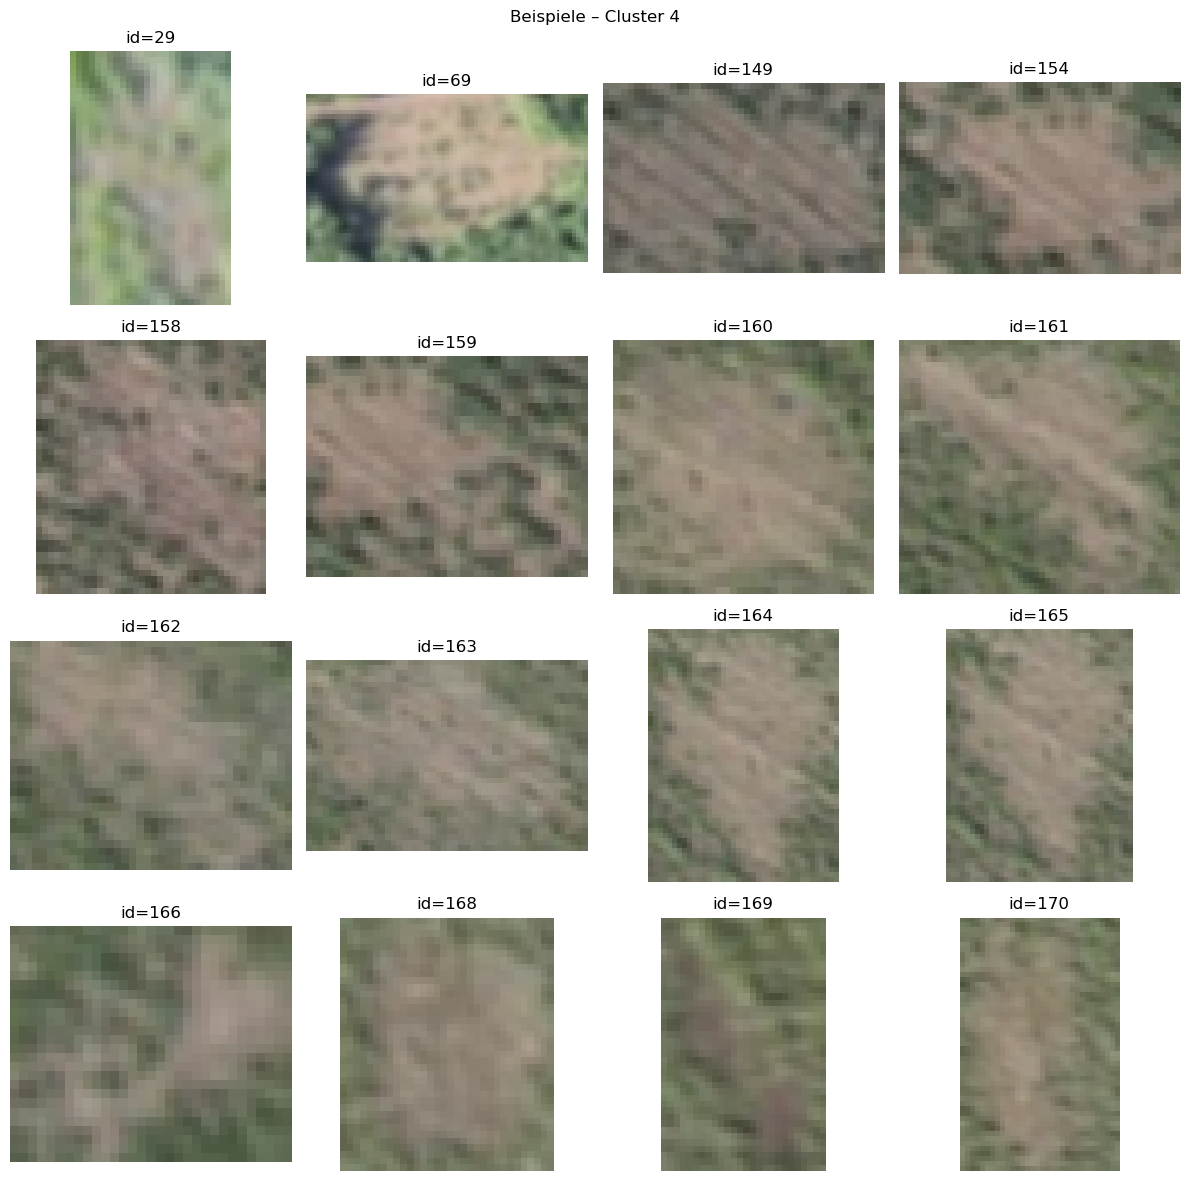

In [26]:
for cid in range(k):
    show_cluster_samples(k_labels, cid, crops, max_images=16)
